In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import warnings
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics     import accuracy_score, roc_auc_score

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
warnings.filterwarnings('once')

In [ ]:
#Reduce if you get Out of Resources error, increase if your computer slows to a halt
BATCH_SIZE = 4

In [3]:
filelist_c = glob.glob('input/china_xrays/*.png')
filelist_m = glob.glob('input/montgomery_xrays/*.png')
filelist = filelist_c + filelist_m

In [4]:
labels = []
for file in filelist:
    #regex to find target
    #[0-9]{4} is the initial 4 numbers after the first underscore, (.+?) to find whatever is between "####_" and ".png"
    current_label = re.findall('[0-9]{4}_(.+?).png', file)
    labels.append(current_label[0])

In [5]:
df = pd.DataFrame(filelist, columns=['file'])
df['target'] = labels
df.head()
targetdf = pd.DataFrame(df.pop('target'), columns=['target'])

In [6]:
traindf, testdf, ytrain, ytest = train_test_split(df, targetdf, stratify=targetdf, test_size=0.1)
traindf['target'] = ytrain
testdf['target'] = ytest
traindf, valdf, ytrain, yval = train_test_split(traindf, traindf['target'], stratify = traindf['target'], test_size = 0.1)
valdf['target']=yval

In [13]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip = True, 
                                    fill_mode = 'nearest', 
                                    cval = 0,
                                    rotation_range=0.05,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.05,
                                    zoom_range=0.05)
                                    
test_generator = ImageDataGenerator(rescale=1./255)

In [14]:
train = train_generator.flow_from_dataframe(dataframe = traindf, class_mode = 'binary', x_col = 'file', y_col = 'target', shuffle = True, batch_size = BATCH_SIZE, target_size = (224,224), color_mode='grayscale')
val = train_generator.flow_from_dataframe(dataframe = valdf, class_mode = 'binary', x_col = 'file', y_col = 'target', shuffle = True, batch_size = BATCH_SIZE, target_size = (224,224), color_mode='grayscale')

Found 648 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.


In [19]:
model = models.Sequential()
model.add(layers.Conv2D(512, (3,3), activation='sigmoid', input_shape=(224,224,1)))
model.add(layers.LayerNormalization())
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(256, (3,3), activation='sigmoid'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='sigmoid'))
model.add(layers.GlobalMaxPool2D())
model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 512)     5120      
                                                                 
 layer_normalization_2 (Laye  (None, 222, 222, 512)    1024      
 rNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 512)    0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 256)     1179904   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 256)      0         
 2D)                                                             
                                                      

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.InverseTimeDecay(0.0001,decay_steps=train.samples//BATCH_SIZE,decay_rate=0.5,staircase=False)), 
              loss='binary_crossentropy',
              metrics=['acc',tf.keras.metrics.Recall()])

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.19196707]
 [0.31276226]
 [0.30225936]
 [0.30580115]
 [0.30448446]
 [0.2992286 ]
 [0.3120624 ]
 [0.29175332]
 [0.2853025 ]
 [0.2772086 ]
 [0.26832098]
 [0.26349983]
 [0.26598445]
 [0.2732902 ]
 [0.2643572 ]
 [0.26965842]
 [0.27411735]
 [0.24929903]
 [0.2580808 ]
 [0.25882354]
 [0.2511858 ]
 [0.24708909]
 [0.23512535]
 [0.22006643]
 [0.23491995]
 [0.22797006]
 [0.23429818]
 [0.22514713]
 [0.2392157 ]
 [0.23976502]
 [0.23816316]
 [0.20898789]
 [0.19991171]
 [0.21736449]
 [0.2171486 ]
 [0.19903041]
 [0.20467384]
 [0.19946508]
 [0.20784315]
 [0.20274805]
 [0.19754176]
 [0.20358716]
 [0.18862289]
 [0.17490704]
 [0.17745703]
 [0.17406304]
 [0.16968879]
 [0.1766855 ]
 [0.1744748 ]
 [0.17447238]
 [0.17254902]
 [0.15754718]
 [0.16725372]
 [0.1774497 ]
 [0.16546765]
 [0.16565013]
 [0.16361676]
 [0.1736733 ]
 [0.17244144]
 [0.17679553]
 [0.17200677]
 [0.17149504]
 [0.16666898]
 [0.17976823]
 [0.17

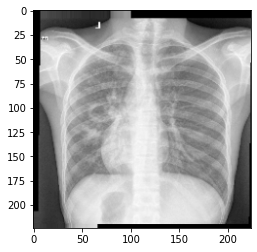

In [21]:
image, label = val.next()
plt.imshow(image[0],cmap='gray')
print(image[0][0])
print(image[0].shape)

In [22]:
model.fit(train, epochs=10, steps_per_epoch=train.samples//4, verbose=1, validation_data=val, validation_steps=val.samples//4)


Epoch 1/10
162/162 [==============================] - 64s 388ms/step - loss: 0.7056 - acc: 0.4722 - recall_2: 0.3625 - val_loss: 0.6921 - val_acc: 0.5556 - val_recall_2: 0.7143
Epoch 2/10
162/162 [==============================] - 63s 385ms/step - loss: 0.6974 - acc: 0.5077 - recall_2: 0.5813 - val_loss: 0.6928 - val_acc: 0.5000 - val_recall_2: 0.0000e+00
Epoch 3/10
162/162 [==============================] - 63s 387ms/step - loss: 0.6954 - acc: 0.5093 - recall_2: 0.3781 - val_loss: 0.6923 - val_acc: 0.4583 - val_recall_2: 0.4571
Epoch 4/10
162/162 [==============================] - 63s 391ms/step - loss: 0.6932 - acc: 0.5262 - recall_2: 0.4531 - val_loss: 0.6900 - val_acc: 0.5694 - val_recall_2: 0.6571
Epoch 5/10
162/162 [==============================] - 64s 393ms/step - loss: 0.6901 - acc: 0.5432 - recall_2: 0.5156 - val_loss: 0.6831 - val_acc: 0.5972 - val_recall_2: 0.8000
Epoch 6/10
162/162 [==============================] - 64s 392ms/step - loss: 0.6850 - acc: 0.5787 - recall_2: 0

In [24]:
test = test_generator.flow_from_dataframe(dataframe = testdf, class_mode='binary', x_col='file', y_col='target',shuffle=False, batch_size=4)
preds = model.predict(test, steps=test.samples//4)
print('acc: ' + str(roc_auc_score(testdf['target'].astype('uint8'), preds)))
print('auc: ' + str(accuracy_score(testdf['target'].astype('uint8'), preds)))

Found 80 validated image filenames belonging to 2 classes.


NotFoundError: Graph execution error:

Detected at node 'sequential_2/conv2d_6/Conv2D' defined at (most recent call last):
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\iblit\AppData\Local\Temp\ipykernel_21612\4168148049.py", line 2, in <cell line: 2>
      preds = model.predict(test, steps=test.samples//4)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\iblit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_2/conv2d_6/Conv2D'
No algorithm worked!  Error messages:
	 [[{{node sequential_2/conv2d_6/Conv2D}}]] [Op:__inference_predict_function_14867]